# Import data and pre-process

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

df = pd.read_csv('hp_data_dre.csv')
df = df.rename(columns=lambda x: x.replace(' ', ''))
df = df.rename(columns=lambda x: x.replace('HP_ambient_temp', 'T_amb'))
df = df.rename(columns=lambda x: x.replace('[C]', ''))
df = df.drop(['HP_on_off', 'Unnamed:15', 'Unnamed:16', 'HP_AC_Voltage', 'HP_AC_Current'], axis=1)

renaming = {
    'HP_mode:0=cooling,1=heating': 'HP_mode',
    'HP_setpoint': 'T_setpoint',
    'HP_inlet_temp': 'T_in',
    'HP_outlet_temp': 'T_out',
    'HP_compressor_freq[Hz]': 'f_comp',
    'Heat_xfer_rate[W]': 'Q_HP',
    'HP_Power[W]':'W_HP',
    'HP_in_flow[L/min]': 'm_HP'
}
df = df.rename(columns=renaming)

df['avg_amb'] = df[['T_amb1', 'T_amb2', 'T_amb3']].mean(axis=1)
df['COP'] = df.Q_HP / df.W_HP
df['f_comp'] = df['f_comp']/60

display(df)

,timestamp,HP_mode,T_setpoint,T_in,T_out,T_amb1,T_amb2,T_amb3,m_HP,f_comp,W_HP,Q_HP,avg_amb,COP
0,2024-07-17 9:55:30,0,40,28,28,15,13.3,12.8,23.1,0.0,0,0.000000,13.700000,NaN
1,2024-07-17 9:55:32,0,40,27,28,15,13.1,12.5,23.2,0.0,0,1615.111711,13.533333,inf
2,2024-07-17 9:55:35,0,40,27,28,15,13.1,12.6,23.3,0.0,0,1624.680103,13.566667,inf
3,2024-07-17 9:55:37,0,40,27,28,15,13.0,12.5,23.2,0.0,0,1618.839506,13.500000,inf
4,2024-07-17 9:55:40,0,40,27,28,15,12.9,12.5,23.2,0.0,0,1619.897886,13.466667,inf
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7478,2024-07-17 15:41:01,0,55,28,28,14,12.4,12.4,27.8,0.0,0,0.000000,12.933333,NaN
7479,2024-07-17 15:41:03,0,55,28,28,14,12.3,12.5,27.3,0.0,0,0.000000,12.933333,NaN
7480,2024-07-17 15:41:06,0,55,28,28,14,12.3,12.4,28.0,0.0,0,0.000000,12.900000,NaN
7481,2024-07-17 15:41:09,0,55,28,28,14,12.3,12.2,27.8,0.0,0,0.000000,12.833333,NaN


### Split data by mode (heating or cooling)

In [11]:
df_cooling = df[df.HP_mode == 0]
df_cooling = df_cooling[df_cooling.Q_HP<=0]
df_cooling['COP'] = np.abs(df_cooling['COP'])
df_cooling = df_cooling.reset_index()

df_heating = df[df.HP_mode == 1]
df_heating = df_heating[df_heating.Q_HP>=0]
df_heating = df_heating[df_heating.COP>=0]
df_heating = df_heating.reset_index()

print(f'Heating: {len(df_heating)}\nCooling: {len(df_cooling)}')

Heating: 3648
Cooling: 2174


# Regression

In [12]:
def model(X,a,b1,b2,b3,c1,c2,c3,d1,d2,d3,e1,e2,e5,f1,f2,f4,f5,f8,f9,g):
    x1, x2, x3 = X
    approx = (a 
              + b1*x1 + b2*x2 + b3*x3
              + c1*x1**2 + c2*x2**2 + c3*x3**2
              + d1*x1**3 + d2*x2**3 + d3*x3**3
              + e1*x1*x2 + e2*x1*x3 + e5*x2*x3
              + f1*x1**2*x2 + f2*x1**2*x3 + f4*x2**2*x1 + f5*x2**2*x3 + f8*x3**2*x1 + f9*x3**2*x2
              + g*x1*x2*x3)
    return approx

print('*'*25 + '\nHEATING MODE\n' + '*'*25)

x_t_out = np.array(list(df_heating.T_out))
x_f_comp = np.array(list(df_heating.f_comp))
x_t_amb1 = np.array(list(df_heating.T_amb1))
x_t_amb2 = np.array(list(df_heating.T_amb2))
x_t_amb3 = np.array(list(df_heating.T_amb3))
x_t_avg_amb = np.array(list(df_heating.avg_amb))
X = np.vstack((x_t_out, x_f_comp, x_t_avg_amb))
y_q_hp = np.array(list(df_heating.Q_HP))
y_w_hp = np.array(list(df_heating.W_HP))

popt_qhp, pcov_qhp = curve_fit(model, X, y_q_hp)
popt_whp, pcov_whp = curve_fit(model, X, y_w_hp)
df_heating['Q_HP_advanced'] = model((x_t_out, x_f_comp, x_t_avg_amb), *popt_qhp)
df_heating['W_HP_advanced'] = model((x_t_out, x_f_comp, x_t_avg_amb), *popt_whp)
print(f"\nQ_HP - coefficients:\n{[round(x,2) for x in popt_qhp]}\n")
print(f"W_HP - coefficients:\n{[round(x,2) for x in popt_whp]}\n")

print('*'*25 + '\nCOOLING MODE\n' + '*'*25)

x_t_out = np.array(list(df_cooling.T_out))
x_f_comp = np.array(list(df_cooling.f_comp))
x_t_amb1 = np.array(list(df_cooling.T_amb1))
x_t_amb2 = np.array(list(df_cooling.T_amb2))
x_t_amb3 = np.array(list(df_cooling.T_amb3))
x_t_avg_amb = np.array(list(df_cooling.avg_amb))
X = np.vstack((x_t_out, x_f_comp, x_t_avg_amb))
y_q_hp = np.array(list(df_cooling.Q_HP))
y_w_hp = np.array(list(df_cooling.W_HP))

popt_qhp_cooling, pcov_qhp = curve_fit(model, X, y_q_hp)
popt_whp_cooling, pcov_whp = curve_fit(model, X, y_w_hp)
df_cooling['Q_HP_advanced'] = model((x_t_out, x_f_comp, x_t_avg_amb), *popt_qhp_cooling)
df_cooling['W_HP_advanced'] = model((x_t_out, x_f_comp, x_t_avg_amb), *popt_whp_cooling)
print(f"\nQ_HP - coefficients:\n{[round(x,2) for x in popt_qhp_cooling]}\n")
print(f"W_HP - coefficients:\n{[round(x,2) for x in popt_whp_cooling]}")

*************************
HEATING MODE
*************************

Q_HP - coefficients:
[-129910.75, 6006.35, -276690.59, 8415.47, -94.32, 15920.76, -67.27, 0.69, -24869.53, -4.61, 4582.16, -286.42, 20515.86, -13.68, 0.84, 74.83, 975.3, 6.17, -315.87, -205.7]

W_HP - coefficients:
[10196.75, -338.79, 25462.94, -958.45, 2.46, -12275.71, 25.05, 0.01, 1697.33, -0.19, 45.4, 26.06, -2195.57, 0.69, -0.17, -42.31, 645.79, -0.35, 46.46, 0.68]

*************************
COOLING MODE
*************************

Q_HP - coefficients:
[42966.3, -187.79, -1146133.1, -8584.24, 50.88, 650659.04, 856.96, 0.28, 11280.16, -38.29, 31414.51, -224.74, 45442.85, -101.49, -5.92, -5837.31, -28225.74, 23.12, 382.8, -1174.25]

W_HP - coefficients:
[-2012.54, -18.1, 23597.84, 492.9, -1.86, -37295.7, -52.31, 0.0, 9140.77, 1.93, -600.1, 12.58, 236.95, 1.45, 0.11, 203.49, 972.22, -0.76, -47.15, 22.09]


# Plots and RMSE

In [13]:
def rmse(a, b):
    a, b = list(a), list(b)
    square_error = [(a[i]-b[i])**2 for i in range(len(a))]
    return round(np.sqrt(sum(square_error)/len(square_error))/1000,1)

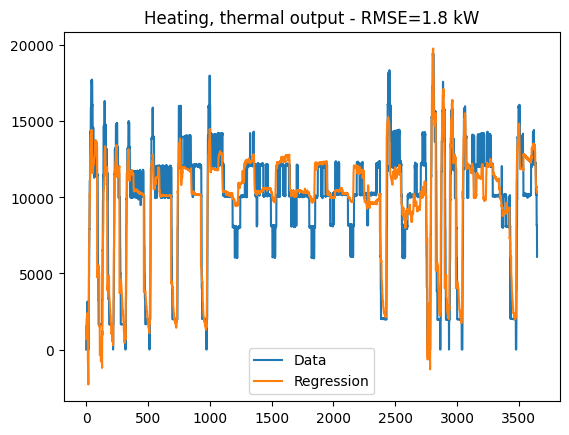

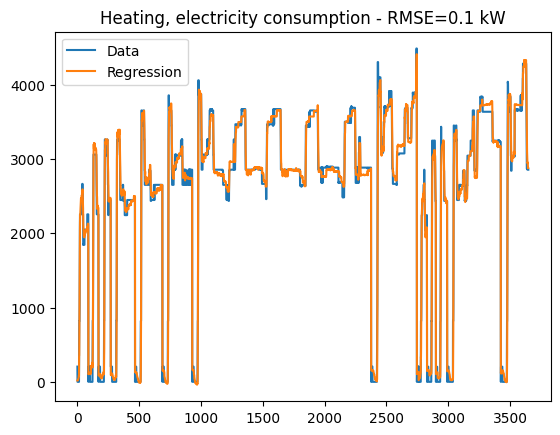

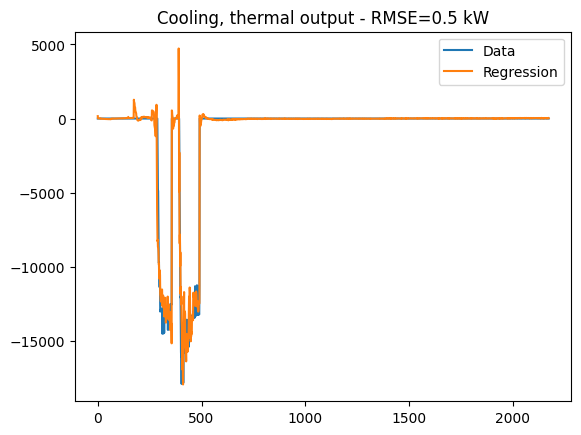

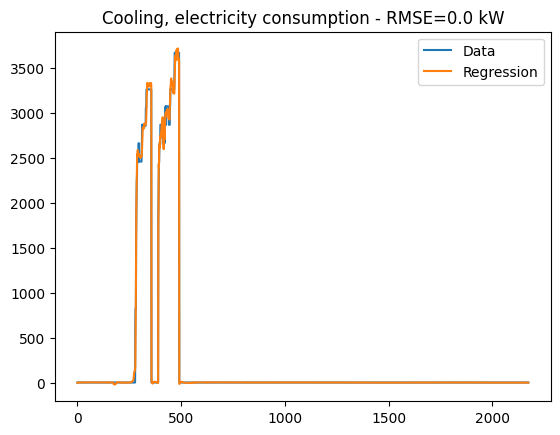

In [14]:
plt.plot(df_heating.Q_HP, label='Data')
plt.plot(df_heating.Q_HP_advanced, label='Regression')
plt.title(f'Heating, thermal output - RMSE={rmse(df_heating.Q_HP, df_heating.Q_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_heating.W_HP, label='Data')
plt.plot(df_heating.W_HP_advanced, label='Regression')
plt.title(f'Heating, electricity consumption - RMSE={rmse(df_heating.W_HP, df_heating.W_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_cooling.Q_HP, label='Data')
plt.plot(df_cooling.Q_HP_advanced, label='Regression')
plt.title(f'Cooling, thermal output - RMSE={rmse(df_cooling.Q_HP, df_cooling.Q_HP_advanced)} kW')
plt.legend()
plt.show()

plt.plot(df_cooling.W_HP, label='Data')
plt.plot(df_cooling.W_HP_advanced, label='Regression')
plt.title(f'Cooling, electricity consumption - RMSE={rmse(df_cooling.W_HP, df_cooling.W_HP_advanced)} kW')
plt.legend()
plt.show()

# Table

In [15]:
t_amb_range = np.linspace(10,30, num=5)
t_out_range = np.linspace(30,55, num=6)
f_com_range = sorted(list(np.linspace(0,1, num=11))+[0.49])

print(f'T_amb range: {[round(x,2) for x in t_amb_range]}')
print(f'T_out range: {[round(x,2) for x in t_out_range]}')
print(f'f_com range: {[round(x,2) for x in f_com_range]}')

def get_W_HP(T_out, f_comp, T_amb):
    return round(model((T_out, f_comp, T_amb), *popt_whp),2) if f_comp >= 0.5 else 0

def get_Q_HP(T_out, f_comp, T_amb):
    return round(model((T_out, f_comp, T_amb), *popt_qhp),2) if f_comp >= 0.5 else 0

elec_power = np.array([[[get_W_HP(T_out, f_comp, T_amb) for f_comp in f_com_range] for T_out in t_out_range] for T_amb in t_amb_range])
heat_power = np.array([[[get_Q_HP(T_out, f_comp, T_amb) for f_comp in f_com_range] for T_out in t_out_range] for T_amb in t_amb_range])

T_amb range: [10.0, 15.0, 20.0, 25.0, 30.0]
T_out range: [30.0, 35.0, 40.0, 45.0, 50.0, 55.0]
f_com range: [0.0, 0.1, 0.2, 0.3, 0.4, 0.49, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]


In [16]:
elec_power

array([[[    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          4005.7 ,  4414.49,  4742.65,  5000.34,  5197.77,  5345.1 ],
        [    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          3974.89,  4408.92,  4758.08,  5032.55,  5242.52,  5398.17],
        [    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          4030.57,  4493.29,  4866.9 ,  5161.6 ,  5387.57,  5554.98],
        [    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          4177.14,  4672.  ,  5073.52,  5391.89,  5637.3 ,  5819.93],
        [    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          4418.99,  4949.43,  5382.31,  5727.81,  5996.11,  6197.4 ],
        [    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          4760.52,  5330.  ,  5797.68,  6173.74,  6468.38,  6691.78]],

       [[    0.  ,     0.  ,     0.  ,     0.  ,     0.  ,     0.  ,
          2017.07,  2274.15,  2515.17,  2750.31,  2989.76,  3243.7 ],
        [    0.  ,     0.

In [17]:
heat_power

array([[[     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  , -18903.84, -22063.67, -25560.43, -29543.35,
         -34161.62, -39564.48],
        [     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  , -12855.42, -15156.14, -17786.3 , -20895.13,
         -24631.84, -29145.65],
        [     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  ,  -7811.56,  -9321.56, -11153.52, -13456.66,
         -16380.21, -20073.37],
        [     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  ,  -3253.5 ,  -4041.18,  -5143.34,  -6709.2 ,
          -8887.97, -11828.88],
        [     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  ,   1337.5 ,   1203.74,    762.98,   -133.99,
          -1636.4 ,  -3893.46],
        [     0.  ,      0.  ,      0.  ,      0.  ,      0.  ,
              0.  ,   6480.18,   6931.94,   7084.19,   6787.7 ,
           5893.26,   4251.65]],

       [[     0.  ,      0.  ,      0.